# 1. Introdução
------
Este notebook tem por objetivo demonstrar alguns casos de base em matrizes maiores. Para verificar os casos de base com matrizes fundamentais, veja o notebook [aqui](https://github.com/rsautter/GPA/tree/master/Examples/FundamentalMatrix.ipynb).

Neste notebook é apresentado a função de [densidade de probabilidade da distribuição normal](https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal) e a função de [Bessel](https://pt.wikipedia.org/wiki/Fun%C3%A7%C3%A3o_de_Bessel) para os casos de padrões simétricos. Também é apresentado os [ruídos coloridos](http://adsabs.harvard.edu/pdf/1995A%26A...300..707T) e o [ruído de Perlin](https://en.wikipedia.org/wiki/Perlin_noise).



Rode a célula a seguir, caso esteja utilizando o colab. As células a seguir instalam as bibliotecas GPA, ruído colorido e ruído de Perlin. 

In [1]:
!pip install git+https://github.com/rsautter/GPA 

  Cloning https://github.com/rsautter/GPA to /tmp/pip-req-build-jib93zft
  Running command git clone -q https://github.com/rsautter/GPA /tmp/pip-req-build-jib93zft
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for GPA: filename=GPA-3.1-cp37-cp37m-linux_x86_64.whl size=901889 sha256=60ab6a941c72d848b969be32fff66469cf4a1c21bb8ebac255593429c5ea80e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-f94d9aj3/wheels/53/e8/31/3a4b685df72633b43063bc73e03cc56a3f4350eaba6c7c7180
Successfully built GPA


In [2]:
!pip install git+https://github.com/felixpatzelt/colorednoise

  Cloning https://github.com/felixpatzelt/colorednoise to /tmp/pip-req-build-3i_g0055
  Running command git clone -q https://github.com/felixpatzelt/colorednoise /tmp/pip-req-build-3i_g0055
  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3958 sha256=dc8b59ccb3b19921919b62da1bada5c8e30b1209b9f818425ddd701eaf482144
  Stored in directory: /tmp/pip-ephem-wheel-cache-snqhye7t/wheels/43/91/fb/92c0e90d3dd29aa2529675d5c141a8342ecc186c5b28174dde
Successfully built colorednoise


In [3]:
!pip install perlin-noise

  Created wheel for perlin-noise: filename=perlin_noise-1.7-cp37-none-any.whl size=3761 sha256=a19288a055e4e9f4c3142203d3986ede019bcc54bd70ea433dabc8c0805cf513
  Stored in directory: /root/.cache/pip/wheels/78/8f/cb/565ce00d57b7a7eef5a83f3faaa8796e7e077412b8e16bc653
Successfully built perlin-noise


A célula a seguir invoca as bibliotecas de manipulação de vetores, geradora de casos base da física e estatística, plotagem e o próprio GPA 

In [4]:
import GPA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches
import tqdm as tqdm

# bibliotecas que geram funcoes
import scipy.stats as stats
import scipy.special as special

# bibliotecas de ruidos
import colorednoise as cn
from perlin_noise import PerlinNoise

# Para o novo ruido
from scipy.ndimage.filters import gaussian_filter1d
import scipy.signal as signal

### Criando um objeto

In [5]:
ga = GPA.GPA(0.04)

### Plot com classificação

In [6]:
def plotGPAVecClass(mat,ga,vectorsperDimension=10):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    im = plt.imshow(mat,origin='lower',alpha=0.65,cmap = 'jet',extent=[0,len(mat),0,len(mat)])
    plt.colorbar(im,shrink=0.9)
    #meshgrid = np.meshgrid(np.arange(0,len(mat))+.5,np.arange(0,len(mat))+.5)
    #plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.title("Amplitude and Gradient Field")
    
    plt.subplot(1,2,2)
    classificationMap = np.array(ga.unknownP) + 3*np.array(ga.asymmetricalP) + 5*np.array(ga.symmetricalP) 
    cmap = colors.ListedColormap(['white','red','blue'])
    norm = colors.BoundaryNorm([0,2,5,6], cmap.N)
    plt.imshow(classificationMap,origin='lower',cmap=cmap,extent=[0,len(mat),0,len(mat)],alpha=0.65,norm=norm, interpolation='none')
    legendColors = [mpatches.Patch(facecolor='white', label='Unknown', edgecolor='k'),
                    mpatches.Patch(facecolor='red', label='Asymmetrical', edgecolor='k'),
                    mpatches.Patch(facecolor='blue', label='Symmetrical', edgecolor='k')]
    plt.legend(handles=legendColors, bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title("Vector Class")
    plt.show()

# 2. Gauss
-----

Um exemplo notório de matriz para estudo de padrões é a distribuição de densidade de probabilidade da distribuição (PDF) normal. A função é dada por:

$$ f(x) = {1 \over \sigma \sqrt{2\pi}} e^{-{1\over 2} \left({x-\mu \over \sigma}\right)^2}$$

Nesta função $\mu$ é a média, que determina a localização do máximo da função, e $\sigma$ é o desvio padrão. Na implementação da [signal.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html), o parâmetro $\mu$ é chamado loc e $\sigma$ é chamado scale.  


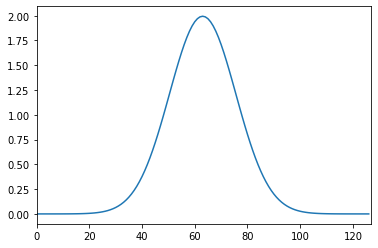

In [7]:
x = np.linspace(-1,1,127)
gauss1D = stats.norm(loc=0.0,scale=0.2).pdf(x)
plt.figure()
plt.plot(gauss1D)
plt.xlim(0,len(gauss1D))
plt.show()

Para gerar a matriz que corresponde a distribuição PDF normal, precisamos primeiramente mapear em cada elemento da matriz  a distância correspondente, para então aplicar a função. A matriz de distâncias foi calculada utilizado a função [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html), em combinação a funções vetoriais que calculam a distância euclidiana.

Uma alternativa seria gerar uma PDF normal unidimensional e aplicar o produto externo para gerar uma matriz de PDF normal. 

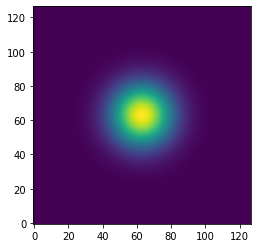

In [8]:
x = np.linspace(-1.0,1.0,127)
dx,dy = np.meshgrid(x,x)
x2D = np.sqrt(dx**2+dy**2)

gauss2D = stats.norm(loc=0.0,scale=0.2).pdf(x2D)

plt.figure()
plt.imshow(gauss2D,origin='lower')
plt.show()

A célula a seguir aplica o algoritmo de GPA nos três primeiros momentos, tanto para a parte simétrica quanto para a parte assimétrica do padrão. 

O valor para a medida relacionada a assimetria deve ser nulo, uma vez que não há vetores assimétricos. Enquanto o primeiro e segundo momento da parte simétrica devem tender a 2, por se tratar de um campo gradiente com padrão regular e alta variabilidade de módulo. O terceiro momento do campo gradiente para a parte simétrica é no entanto a constante 1, pois os vetores estão alinhados ao centro da matriz.

In [9]:
moments = ga(gauss2D, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(gauss2D, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(gauss2D, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(gauss2D, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente simétrico: {'G1': 1.991, 'G2': 1.925, 'G3': 1.0}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.991, 'G2': 2.0, 'G3': 1.0}
Momentos do campo gradiente completo: {'G1': 2.0, 'G2': 2.0, 'G3': 1.0}


A célula a seguir mostra alguns vetores e a classificação do campo vetorial. O ponto central da matriz e a parte externa possuem módulo próximo a zero, dificultando assim a determinação a direção. Sendo assim, esses vetores foram classificados como indeterminados. 

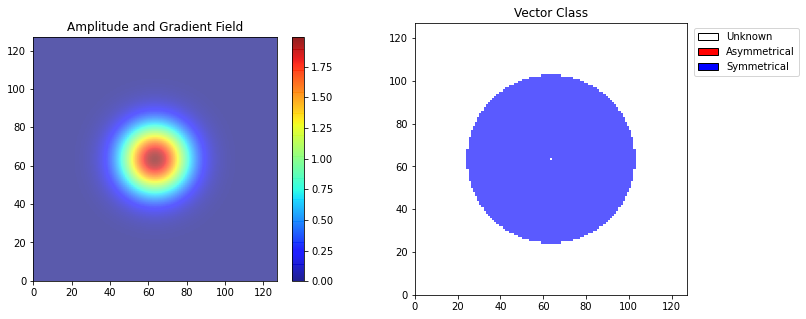

In [10]:
plotGPAVecClass(gauss2D,ga)

# 3. Bessel
-----

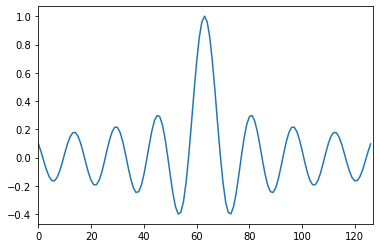

In [11]:
x = np.linspace(-25.0,25.0,127)
besselJ01D = special.j0(x)
plt.figure()
plt.plot(besselJ01D)
plt.xlim(0,len(besselJ01D))
plt.show()

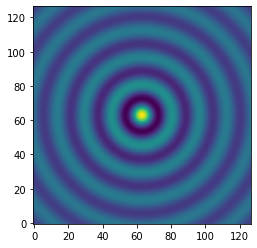

In [12]:
x = np.linspace(-25.0,25.0,127)
dx,dy = np.meshgrid(x,x)
x2D = np.sqrt(dx**2+dy**2)

besselJ02D = special.j0(x2D)

plt.figure()
plt.imshow(besselJ02D,origin='lower')
plt.show()

A célula a seguir aplica o algoritmo de GPA nos três primeiros momentos, tanto para a parte simétrica quanto para a parte assimétrica do padrão. 

O valor para a medida relacionada a assimetria deve ser nulo, uma vez que não há vetores assimétricos. Enquanto o primeiro e segundo momento da parte simétrica devem tender a 2, por se tratar de um campo gradiente com padrão com vetores espalhados regularmente e que possuem alta variabilidade de módulo. O terceiro momento do campo gradiente para a parte simétrica é no entanto tende a constante 1.5, pois todos vetores estão alinhados o centro da matriz. Diferentemente da PDF normal, os vetores variam de sentido, metade dos vetores simétricos apontam para o centro da matriz e a outra metade aponta para a parte externa da matriz. Sendo assim, a medida é similar ao rotacional do campo gradiente.

In [13]:
moments = ga(besselJ02D, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(besselJ02D, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(besselJ02D, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(besselJ02D, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0}
Momentos do campo gradiente simétrico: {'G1': 1.997, 'G2': 1.972, 'G3': 1.514}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.997, 'G2': 2.0, 'G3': 1.514}
Momentos do campo gradiente completo: {'G1': 1.998, 'G2': 2.0, 'G3': 1.509}


Novamente o ponto central do padrão possui um vetor indeterminado quanto à simetria, devido a incapacidade de determinar a direção do vetor. No entanto, diferentemente da PDF normal, a função de Bessel possui outros pontos críticos. Vales e cristas possuem também derivada próxima a zero.

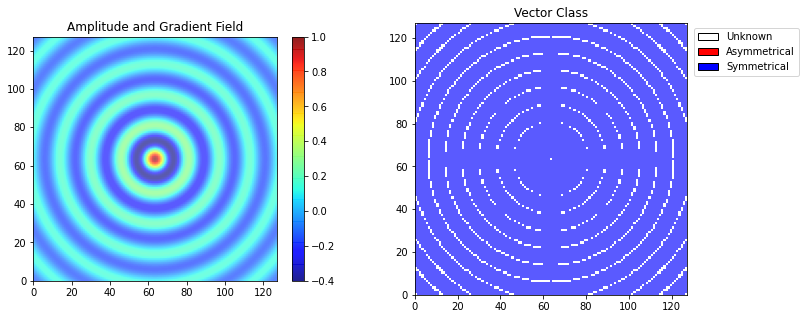

In [14]:
plotGPAVecClass(besselJ02D,ga)

# 4. Ruídos coloridos

In [15]:
white = cn.powerlaw_psd_gaussian(exponent=0.0, size=(127,127))
pink = cn.powerlaw_psd_gaussian(exponent=1.0, size=(127,127))
brown = cn.powerlaw_psd_gaussian(exponent=2.0, size=(127,127))
reddish = cn.powerlaw_psd_gaussian(exponent=5.0, size=(127,127))

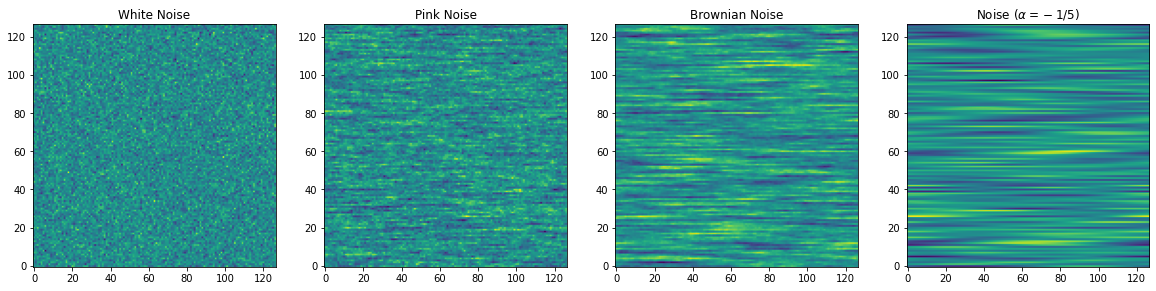

In [16]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.imshow(white,origin='lower')
plt.title("White Noise")

plt.subplot(1,4,2)
plt.imshow(pink,origin='lower')
plt.title("Pink Noise")

plt.subplot(1,4,3)
plt.imshow(brown,origin='lower')
plt.title("Brownian Noise")

plt.subplot(1,4,4)
plt.imshow(reddish,origin='lower')
plt.title(r"Noise ($\alpha = -1/5$)")

plt.show()

In [17]:
moments = ga(white, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(white, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(white, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(white, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.95, 'G2': 0.058, 'G3': 0.532}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G2': 1.977, 'G3': 1.469}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.998, 'G2': 1.983, 'G3': 1.502}
Momentos do campo gradiente completo: {'G1': 1.998, 'G2': 1.983, 'G3': 1.502}


In [18]:
moments = ga(pink, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(pink, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(pink, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(pink, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.964, 'G2': 0.069, 'G3': 0.523}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G2': 1.975, 'G3': 1.462}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.998, 'G2': 1.976, 'G3': 1.499}
Momentos do campo gradiente completo: {'G1': 1.999, 'G2': 1.975, 'G3': 1.499}


In [19]:
moments = ga(brown, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(brown, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(brown, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(brown, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.953, 'G2': 0.028, 'G3': 0.535}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G2': 1.964, 'G3': 1.47}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.998, 'G2': 1.978, 'G3': 1.497}
Momentos do campo gradiente completo: {'G1': 1.998, 'G2': 1.978, 'G3': 1.497}


In [20]:
moments = ga(reddish, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(reddish, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(reddish, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(reddish, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.755, 'G2': 0.001, 'G3': 0.447}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G2': 1.967, 'G3': 1.484}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.996, 'G2': 1.948, 'G3': 1.495}
Momentos do campo gradiente completo: {'G1': 1.997, 'G2': 1.938, 'G3': 1.492}


# 5. Ruído de Perlin
----

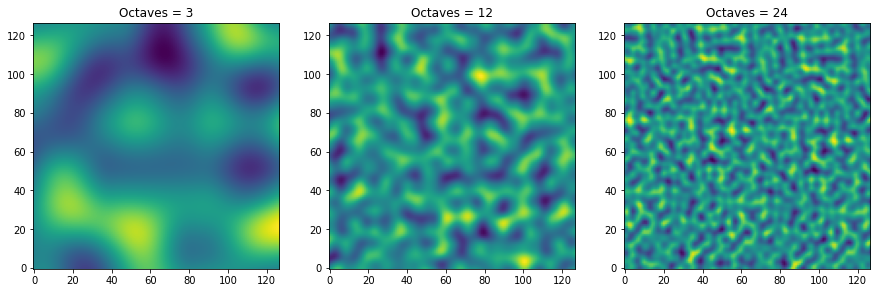

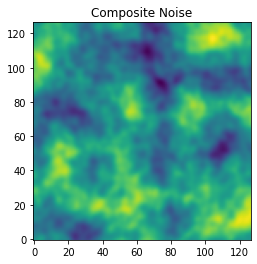

In [21]:
grid = np.linspace(0,1,127)

oct3x3 = PerlinNoise(octaves=3)
n3x3 = np.array([[oct3x3([x,y])  for x in grid] for y in grid])

oct6x6 = PerlinNoise(octaves=6)
n6x6 = np.array([[oct6x6([x,y])  for x in grid] for y in grid])

oct12x12 = PerlinNoise(octaves=12)
n12x12 = np.array([[oct12x12([x,y])  for x in grid] for y in grid])

oct18x18 = PerlinNoise(octaves=18)
n18x18 = np.array([[oct18x18([x,y])  for x in grid] for y in grid])

oct24x24 = PerlinNoise(octaves=24)
n24x24 = np.array([[oct24x24([x,y])  for x in grid] for y in grid])

decay = 5./3.
composite = n3x3/np.log(decay**3)+n6x6/np.log(decay**6)+n12x12/np.log(decay**12)+n18x18/np.log(decay**18)+n24x24/np.log(decay**24)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(n3x3,origin='lower')
plt.title("Octaves = 3")
plt.subplot(1,3,2)
plt.imshow(n12x12,origin='lower')
plt.title("Octaves = 12")
plt.subplot(1,3,3)
plt.imshow(n24x24,origin='lower')
plt.title("Octaves = 24")
plt.show()

plt.figure()
plt.imshow(composite,origin='lower')
plt.title("Composite Noise")
plt.show()

## 5.1. GPA e frequência espacial

O teste a seguir mostra o resultado do GPA para diferentes escalas de ruído, o objetivo é meramente ilustrativo.

In [22]:
moments = ga(n3x3, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(n3x3, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(n3x3, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(n3x3, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.992, 'G2': 1.04, 'G3': 1.04}
Momentos do campo gradiente simétrico: {'G1': 1.989, 'G2': 1.975, 'G3': 1.005}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.993, 'G2': 1.999, 'G3': 1.523}
Momentos do campo gradiente completo: {'G1': 1.993, 'G2': 1.999, 'G3': 1.523}


In [23]:
moments = ga(n12x12, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(n12x12, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(n12x12, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(n12x12, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.99, 'G2': 0.201, 'G3': 0.594}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G2': 1.979, 'G3': 1.398}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.999, 'G2': 2.0, 'G3': 1.499}
Momentos do campo gradiente completo: {'G1': 1.999, 'G2': 2.0, 'G3': 1.498}


In [24]:
moments = ga(n24x24, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(n24x24, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(n24x24, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(n24x24, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.989, 'G2': 0.172, 'G3': 0.6}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G2': 1.977, 'G3': 1.407}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.999, 'G2': 2.0, 'G3': 1.495}
Momentos do campo gradiente completo: {'G1': 1.999, 'G2': 2.0, 'G3': 1.495}


## 5.2. GPA e ruido composto

Para mimetizar os padrões observados na geografia de um terreno e da dinâmica de fluidos, geralmente utiliza-se uma composição de ruídos em diversas escalas 

In [25]:
moments = ga(composite, moment=['G1','G2','G3'],symmetrycalGrad='A')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(composite, moment=['G1','G2','G3'],symmetrycalGrad='S')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(composite, moment=['G1','G2','G3'],symmetrycalGrad='K')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(composite, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : round(moments[key], 3) for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.993, 'G2': 0.237, 'G3': 0.591}
Momentos do campo gradiente simétrico: {'G1': 1.998, 'G2': 1.976, 'G3': 1.403}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.998, 'G2': 1.999, 'G3': 1.516}
Momentos do campo gradiente completo: {'G1': 1.999, 'G2': 1.999, 'G3': 1.516}


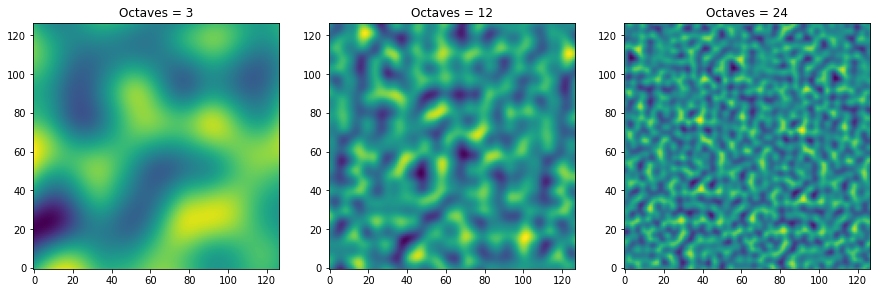

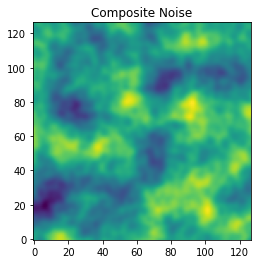

In [26]:
grid = np.linspace(0,1,127)

oct3x3 = PerlinNoise(octaves=3)
n3x3 = np.array([[oct3x3([x,y])  for x in grid] for y in grid])

oct6x6 = PerlinNoise(octaves=6)
n6x6 = np.array([[oct6x6([x,y])  for x in grid] for y in grid])

oct12x12 = PerlinNoise(octaves=12)
n12x12 = np.array([[oct12x12([x,y])  for x in grid] for y in grid])

oct18x18 = PerlinNoise(octaves=18)
n18x18 = np.array([[oct18x18([x,y])  for x in grid] for y in grid])

oct24x24 = PerlinNoise(octaves=24)
n24x24 = np.array([[oct24x24([x,y])  for x in grid] for y in grid])

decay = 5./3.
composite = n3x3/np.log(decay**3)+n6x6/np.log(decay**6)+n12x12/np.log(decay**12)+n18x18/np.log(decay**18)+n24x24/np.log(decay**24)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(n3x3,origin='lower')
plt.title("Octaves = 3")
plt.subplot(1,3,2)
plt.imshow(n12x12,origin='lower')
plt.title("Octaves = 12")
plt.subplot(1,3,3)
plt.imshow(n24x24,origin='lower')
plt.title("Octaves = 24")
plt.show()

plt.figure()
plt.imshow(composite,origin='lower')
plt.title("Composite Noise")
plt.show()

### 5.2.1. Teste de decaimento do ruído


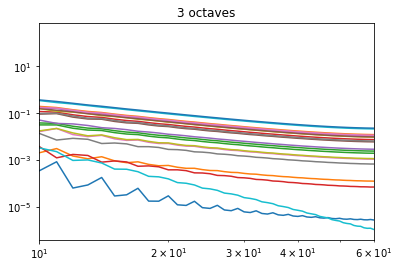

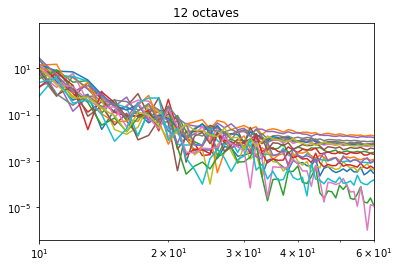

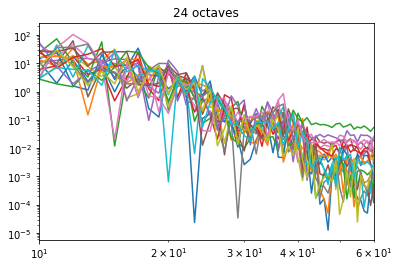

In [ ]:
loc = np.linspace(0,126,20)

plt.figure()
plt.title("3 octaves")
for i in loc:
  ft = np.fft.fft(n3x3)[np.int(i)]
  plt.loglog(np.real(ft*np.conj(ft)))
plt.xlim(10,60)

plt.figure()
plt.title("12 octaves")
for i in loc:
  ft = np.fft.fft(n12x12)[np.int(i)]
  plt.loglog(np.real(ft*np.conj(ft)))
plt.xlim(10,60)

plt.figure()
plt.title("24 octaves")
for i in loc:
  ft = np.fft.fft(n24x24)[np.int(i)]
  plt.loglog(np.real(ft*np.conj(ft)))
plt.xlim(10,60)
plt.show()
